# Random Forest Classifier for Recipe Reviews and User Feedback Dataset

This notebook implements a Random Forest classifier for the Recipe Reviews and User Feedback Dataset from UCI (https://archive.ics.uci.edu/dataset/911/recipe+reviews+and+user+feedback+dataset), as required for the VU Machine Learning 2025S assignment. The dataset contains 18,182 instances with 15 features (e.g., recipe name, user reputation, comment text) and a target variable `stars` (0–5 scale, 0 for no rating). The task is to predict the `stars` rating based on numerical and categorical features (excluding text). The code follows the lecture steps:
- **Data Import**: Load the dataset CSV.
- **Data Exploration**: Check class distribution, missing values, and feature distributions.
- **Preprocessing**: Handle missing values, encode categorical features, scale numerical features, split data.
- **Classification**: Run Random Forest with multiple parameter settings.
- **Evaluation**: Use accuracy, F1-score, ROC-AUC, cross-validation, and runtime metrics.
- **Visualization**: Generate confusion matrix and parameter impact plots.

**Objective**: Classify user ratings (stars) for recipes based on review and user features.

## Step 1: Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import time
import os
%matplotlib inline

## Step 2: Data Exploration

Load the dataset and explore class distribution, missing values, and feature statistics.


Dataset Shape: (18182, 15)

First 5 Rows:
    Unnamed: 0  recipe_number  recipe_code         recipe_name  \
0           0              1        14299  Creamy White Chili   
1           1              1        14299  Creamy White Chili   
2           2              1        14299  Creamy White Chili   
3           3              1        14299  Creamy White Chili   
4           4              1        14299  Creamy White Chili   

                                        comment_id         user_id  \
0  sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM  u_9iFLIhMa8QaG   
1  sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY  u_Lu6p25tmE77j   
2  sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP  u_s0LwgpZ8Jsqq   
3  sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC  u_fqrybAdYjgjG   
4  sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI  u_XXWKwVhKZD69   

    user_name  user_reputation  created_at  reply_count  thumbs_up  \
0     Jeri326                1  1665619889            0          0   
1   

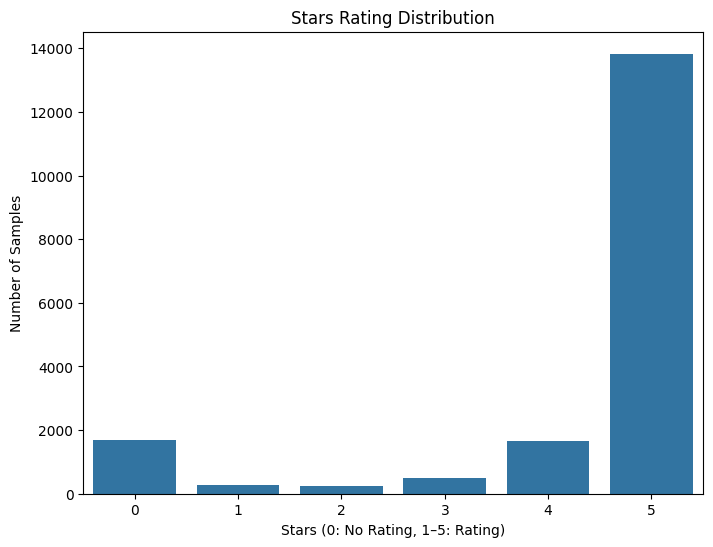


Missing Values:
 text    2
dtype: int64

Columns with value 2 (potential missing values):
 Unnamed: 0         100
recipe_number      509
recipe_code          0
recipe_name          0
comment_id           0
user_id              0
user_name            0
user_reputation      0
created_at           0
reply_count         24
thumbs_up          624
thumbs_down        388
stars              232
best_score           0
text                 0
dtype: int64

Feature Statistics (Numerical):
          Unnamed: 0  recipe_number    recipe_code  user_reputation  \
count  18182.000000   18182.000000   18182.000000     18182.000000   
mean     121.465295      38.689363   21773.667253         2.159608   
std      116.747893      29.786647   23965.109637        10.014666   
min        0.000000       1.000000     386.000000         0.000000   
25%       45.000000      12.000000    6086.000000         1.000000   
50%       91.000000      33.000000   14600.000000         1.000000   
75%      150.000000      6

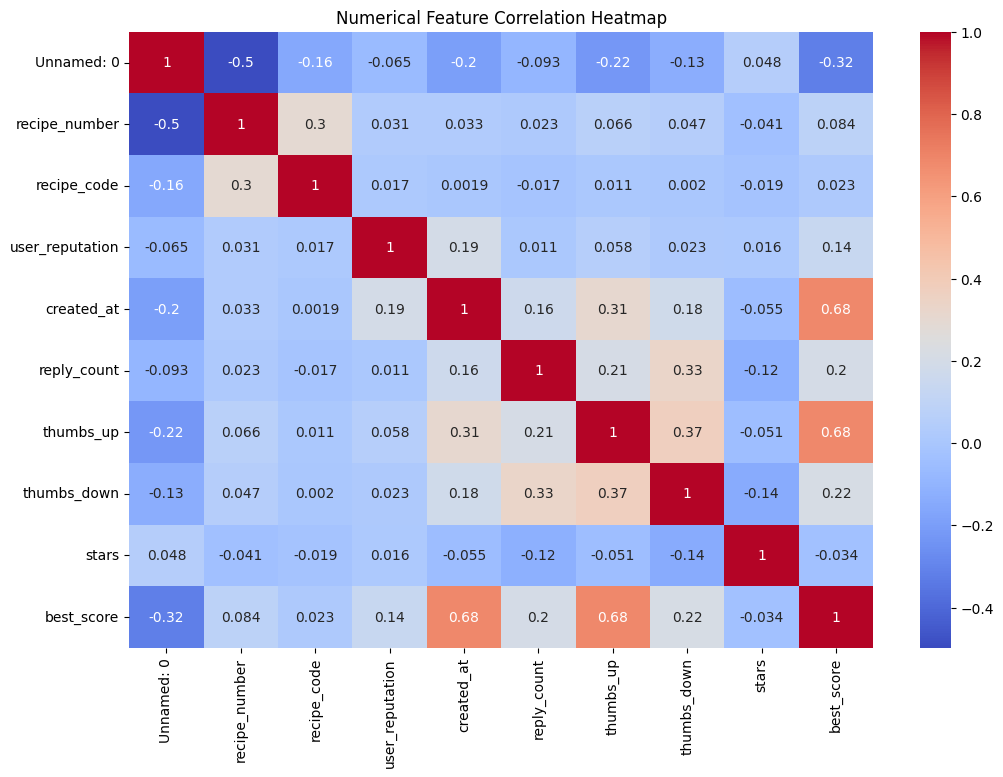

In [13]:
def explore_dataset(df):
    """Explore dataset structure, class distribution, and missing values."""
    print("\nDataset Shape:", df.shape)
    print("\nFirst 5 Rows:\n", df.head())
    print("\nData Types:\n", df.dtypes)
    
    # Class distribution
    class_counts = df['stars'].value_counts()
    print("\nClass Distribution (Stars):\n", class_counts)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Stars Rating Distribution')
    plt.xlabel('Stars (0: No Rating, 1–5: Rating)')
    plt.ylabel('Number of Samples')
    plt.savefig('class_distribution_recipe.png')
    plt.show()
    
    # Missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:\n", missing_values[missing_values > 0])
    
    # Check for special missing value indicator (2)
    print("\nColumns with value 2 (potential missing values):\n", (df == 2).sum())
    
    # Feature statistics (numerical features only)
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    print("\nFeature Statistics (Numerical):\n", df[numerical_cols].describe())
    
    # Feature correlations (numerical features)
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols].corr(), cmap='coolwarm', annot=True)
    plt.title('Numerical Feature Correlation Heatmap')
    plt.savefig('feature_correlation_recipe.png')
    plt.show()

# Load dataset
data_path = 'Recipe Reviews and User Feedback Dataset.csv'  # Update with local path
df = pd.read_csv(data_path)

# Explore dataset
explore_dataset(df)

## Step 3: Preprocessing

Handle missing values, encode categorical features, scale numerical features, and split data.

In [14]:
def preprocess_data(df):
    """Preprocess the dataset: handle missing values, encode features, scale, split data."""
    # Drop text and non-predictive ID columns
    drop_cols = ['text', 'comment_id', 'user_id', 'user_name']
    df = df.drop(columns=drop_cols)
    
    # Replace special missing value indicator (2) with NaN
    df = df.replace(2, np.nan)
    
    # Drop rows where target 'stars' is NaN
    df = df.dropna(subset=['stars'])
    
    # Separate features and target
    feature_cols = [col for col in df.columns if col != 'stars']
    X = df[feature_cols]
    y = df['stars']
    
    # Handle categorical features
    categorical_cols = X.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # Impute missing values for numerical features
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    if len(numerical_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
    
    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data (80% train, 20% test, stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nTraining samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test, y

# Preprocess data
X_train, X_test, y_train, y_test, y = preprocess_data(df)


Training samples: 14360, Testing samples: 3590


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_4499/4291658825.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_4499/4291658825.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])


## Step 4: Random Forest Experiments

Run Random Forest with different parameter settings, evaluate using holdout and cross-validation.

In [15]:
def run_rf_experiments(X_train, y_train, X_test, y_test, class_names):
    """Run Random Forest experiments with different parameter settings."""
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2]
    }
    
    # Initialize results storage
    results = []
    
    # Experiment with parameter settings
    print("\n=== Random Forest Experiments ===")
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for max_features in param_grid['max_features']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        print(f"\nTesting: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, max_features={max_features}, min_samples_leaf={min_samples_leaf}")
                        
                        # Initialize classifier
                        rf_classifier = RandomForestClassifier(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42,
                            class_weight='balanced'
                        )
                        
                        # Measure training time
                        start_time = time.time()
                        rf_classifier.fit(X_train, y_train)
                        training_time = time.time() - start_time
                        
                        # Holdout evaluation
                        start_time = time.time()
                        predictions = rf_classifier.predict(X_test)
                        prediction_time = time.time() - start_time
                        
                        # Performance metrics
                        accuracy = accuracy_score(y_test, predictions)
                        f1 = f1_score(y_test, predictions, average='weighted')
                        roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test), multi_class='ovr')
                        
                        # Cross-validation (5-fold)
                        cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
                        cv_accuracy = np.mean(cv_scores)
                        
                        # Store results
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'max_features': max_features,
                            'min_samples_leaf': min_samples_leaf,
                            'accuracy': accuracy,
                            'f1_score': f1,
                            'roc_auc': roc_auc,
                            'cv_accuracy': cv_accuracy,
                            'training_time': training_time,
                            'prediction_time': prediction_time
                        })
                        
                        # Print results
                        print(f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}, CV Accuracy: {cv_accuracy:.2f}")
                        print(f"Training Time: {training_time:.2f}s, Prediction Time: {prediction_time:.2f}s")
    
    return results


## Step 5: Visualize and Save Results

Save results to CSV, visualize confusion matrix and parameter impact for the best model.

In [16]:
def visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names):
    """Visualize results and save to CSV."""
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:")
    print(results_df)
    
    # Save results
    results_df.to_csv("rf_results_recipe.csv", index=False)
    
    # Find best model
    best_idx = results_df['accuracy'].idxmax()
    # Handle max_depth: convert np.nan to None
    max_depth = results_df.loc[best_idx]['max_depth']
    max_depth = None if pd.isna(max_depth) else int(max_depth)
    
    best_rf = RandomForestClassifier(
        n_estimators=int(results_df.loc[best_idx]['n_estimators']),
        max_depth=max_depth,
        min_samples_split=int(results_df.loc[best_idx]['min_samples_split']),
        max_features=results_df.loc[best_idx]['max_features'],
        min_samples_leaf=int(results_df.loc[best_idx]['min_samples_leaf']),
        random_state=42,
        class_weight='balanced'
    )
    best_rf.fit(X_train, y_train)
    predictions = best_rf.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Random Forest Confusion Matrix')
    plt.savefig('rf_confusion_matrix_recipe.png')
    plt.show()
    
    # Classification report
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, predictions, target_names=class_names))
    
    # Plot accuracy vs. n_estimators
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='n_estimators', y='accuracy', hue='max_depth', style='min_samples_split')
    plt.title('Accuracy vs. n_estimators')
    plt.savefig('rf_accuracy_vs_estimators_recipe.png')
    plt.show()
    
    # Plot accuracy vs. max_depth
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_depth', y='accuracy', hue='n_estimators', style='min_samples_split')
    plt.title('Accuracy vs. max_depth')
    plt.savefig('rf_accuracy_vs_max_depth_recipe.png')
    plt.show()
    
    # Plot accuracy vs. max_features
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_features', y='accuracy', hue='n_estimators', style='min_samples_leaf')
    plt.title('Accuracy vs. max_features')
    plt.savefig('rf_accuracy_vs_max_features_recipe.png')
    plt.show()


## Step 6: Main Execution

Run experiments and visualize results.

Class names: ['0 Stars', '1 Star', '3 Stars', '4 Stars', '5 Stars']

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.77, F1-Score: 0.71, ROC-AUC: 0.66, CV Accuracy: 0.76
Training Time: 2.04s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.73, F1-Score: 0.70, ROC-AUC: 0.68, CV Accuracy: 0.73
Training Time: 1.24s, Prediction Time: 0.04s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.77, F1-Score: 0.71, ROC-AUC: 0.66, CV Accuracy: 0.76
Training Time: 1.34s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.73, F1-Score: 0.70, ROC-AUC: 0.68, CV Accuracy: 0.73
Training Time: 1.17s, Prediction Time: 0.04s

Testing: n_estimators=50, max_depth=None, min_sa

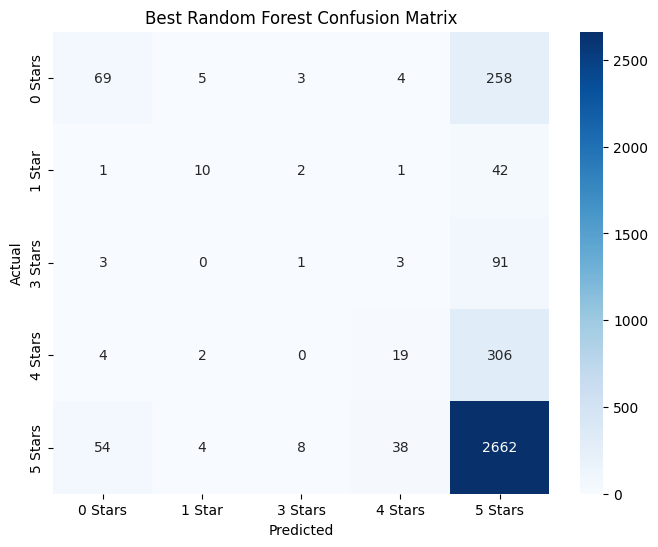


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.53      0.20      0.29       339
      1 Star       0.48      0.18      0.26        56
     3 Stars       0.07      0.01      0.02        98
     4 Stars       0.29      0.06      0.10       331
     5 Stars       0.79      0.96      0.87      2766

    accuracy                           0.77      3590
   macro avg       0.43      0.28      0.31      3590
weighted avg       0.70      0.77      0.71      3590



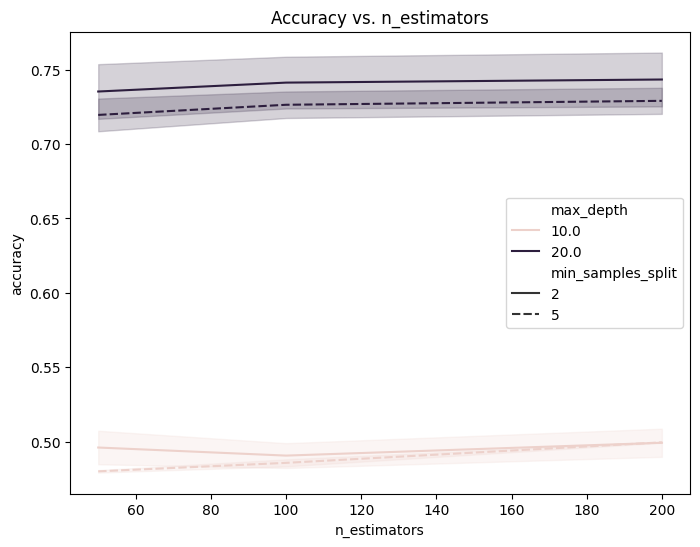

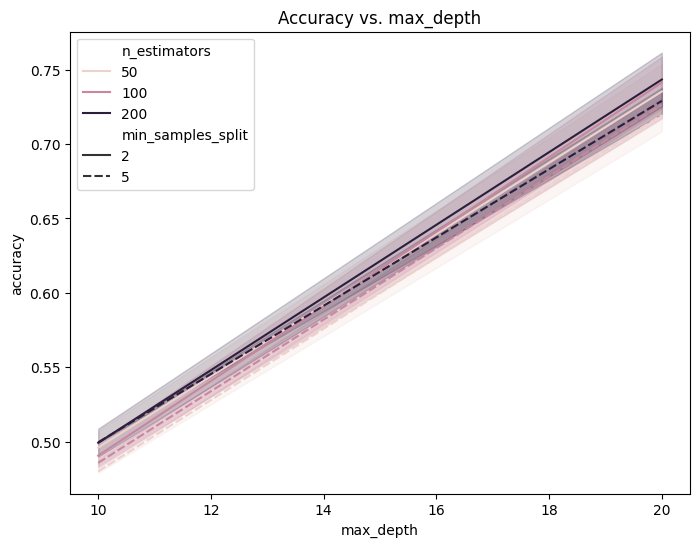

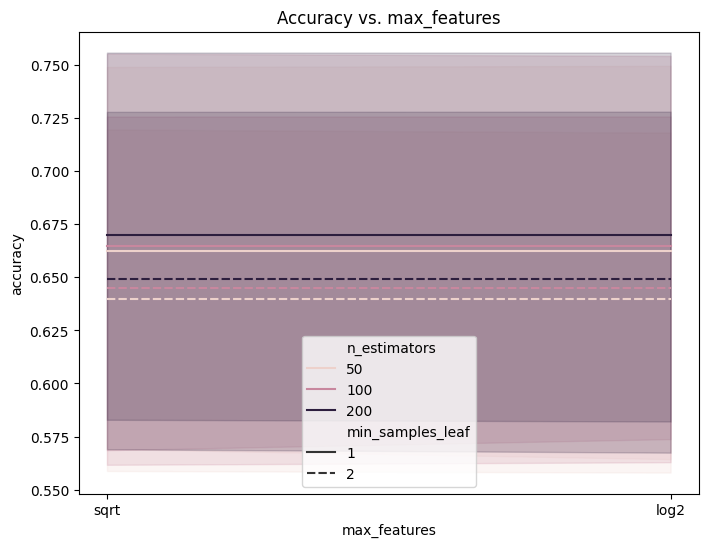

In [17]:
# Define class names dynamically based on unique values in y
class_names = [f"{int(label)} Star{'s' if label != 1 else ''}" for label in sorted(y.unique())]
print("Class names:", class_names)

# Run experiments
results = run_rf_experiments(X_train, y_train, X_test, y_test, class_names)

# Visualize and save results
visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names)